In [1]:
import os
import cv2

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("alzheimer_train_valid.csv")
test_df = pd.read_csv("alzheimer_benchamrk.csv")

In [3]:
train_df, valid_df = train_test_split(train, test_size=0.2, stratify=train['class'], random_state=42)

In [4]:
print("     Train set size:", len(train_df))
print("Validation set size:", len(valid_df))
print("      Test set size:", len(test_df))

     Train set size: 10175
Validation set size: 2544
      Test set size: 600


In [5]:
print("\nTrain set class distribution:")
print(train_df['class'].value_counts())

print("\nValidation set class distribution:")
print(valid_df['class'].value_counts())

print("\nTest set class distribution:")
print(test_df['class'].value_counts())


Train set class distribution:
class
Very_Mild_Demented    2952
Mild_Demented         2515
Non_Demented          2440
Moderate_Demented     2268
Name: count, dtype: int64

Validation set class distribution:
class
Very_Mild_Demented    738
Mild_Demented         629
Non_Demented          610
Moderate_Demented     567
Name: count, dtype: int64

Test set class distribution:
class
Non_Demented          150
Very_Mild_Demented    150
Moderate_Demented     150
Mild_Demented         150
Name: count, dtype: int64


In [6]:
def extract_rgb_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (130, 130))
    return image.flatten()

In [7]:
train_features = [extract_rgb_features(image_path) for image_path in train_df['image_path']]
train_features = np.array(train_features)

valid_features = [extract_rgb_features(image_path) for image_path in valid_df['image_path']]
valid_features = np.array(valid_features)

test_features = [extract_rgb_features(image_path) for image_path in test_df['image_path']]
test_features = np.array(test_features)

In [8]:
print("     Train features shape:", train_features.shape)
print("Validation features shape:", valid_features.shape)
print("      Test features shape:", test_features.shape)

# 128 * 128 * 3 = 49152

     Train features shape: (10175, 50700)
Validation features shape: (2544, 50700)
      Test features shape: (600, 50700)


# Support Vector Machine

In [9]:
param_dist = {
    'C': np.logspace(-3, 3, 7), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),  
}

In [10]:
svm_classifier = SVC(random_state=42, probability=True)

In [11]:
random_search = RandomizedSearchCV(svm_classifier, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)
random_search.fit(train_features, train_df['class'])
best_svm_classifier = random_search.best_estimator_
best_svm_classifier

In [ ]:
model_filename = 'best_svm_classifier_model.joblib'
joblib.dump(best_svm_classifier, model_filename)
print("Best model saved as", model_filename)

Best model saved as best_svm_classifier_model.joblib


In [ ]:
new_image_path = 'Benchmark/Moderate_Demented/augmented_3_moderate_6.jpg'
loaded_best_svm_classifier = joblib.load(model_filename)
new_image_features = extract_rgb_features(new_image_path)
new_image_features = np.array(new_image_features).reshape(1, -1)  
predicted_class = loaded_best_svm_classifier.predict(new_image_features)[0]
print("Predicted class:", predicted_class)

Predicted class: Mild_Demented


In [ ]:
predictions = loaded_best_svm_classifier.predict(test_features)

In [ ]:
confusion_mat = confusion_matrix(test_df['class'], predictions)
unique_classes = np.unique(test_df['class'])
confusion_df = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

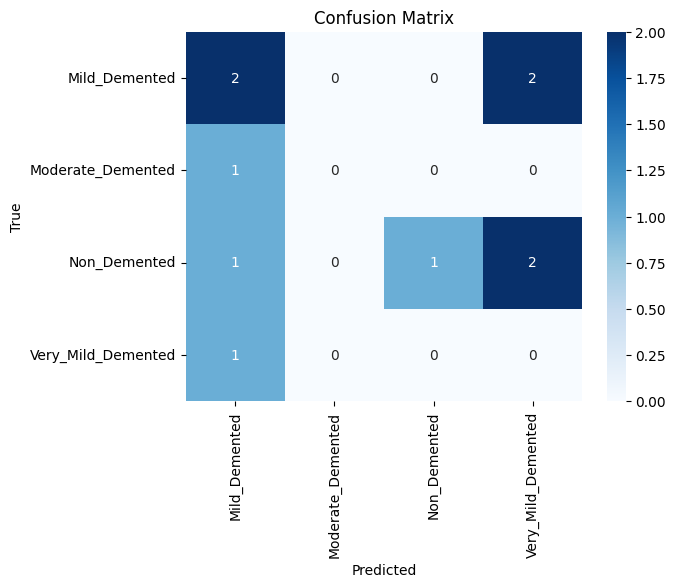

Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.40      0.50      0.44         4
 Moderate_Demented       0.00      0.00      0.00         1
      Non_Demented       1.00      0.25      0.40         4
Very_Mild_Demented       0.00      0.00      0.00         1

          accuracy                           0.30        10
         macro avg       0.35      0.19      0.21        10
      weighted avg       0.56      0.30      0.34        10



In [ ]:

sns.heatmap(confusion_df, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(test_df['class'], predictions)
print("Classification Report:\n", class_report)

In [ ]:
model_filename = 'best_svm_classifier_model.joblib'
loaded_best_svm_classifier = joblib.load(model_filename)
class_names = loaded_best_svm_classifier.classes_

In [ ]:
predicted_classes = []
confidence_scores = []

for index, row in test_df.iterrows():
    image_path = row['image_path']
    image_features = extract_rgb_features(image_path)
    image_features = np.array(image_features).reshape(1, -1)
    decision_distances = loaded_best_svm_classifier.decision_function(image_features)
    confidence_scores.append(decision_distances)
    predicted_class_index = np.argmax(decision_distances)
    predicted_class = class_names[predicted_class_index]
    predicted_classes.append(predicted_class)

In [ ]:
reshaped_scores = np.array([arr[0] for arr in confidence_scores])
confidence_df = pd.DataFrame(reshaped_scores, columns=class_names)

In [ ]:
test_df['predicted_class'] = predicted_classes
data_df = pd.concat([test_df, confidence_df], axis=1)
data_df

,image_path,class,predicted_class,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented
0,Benchmark\Non_Demented\non_825.jpg,Non_Demented,Very_Mild_Demented,-0.137954,0.845798,2.089792,3.181696
1,Benchmark\Moderate_Demented\augmented_81_moder...,Moderate_Demented,Mild_Demented,3.229493,0.864344,-0.224304,2.115966
2,Benchmark\Non_Demented\non_272.jpg,Non_Demented,Mild_Demented,3.219208,0.813810,-0.198441,2.149750
3,Benchmark\Very_Mild_Demented\verymild_1888.jpg,Very_Mild_Demented,Mild_Demented,3.237129,0.904830,-0.231549,2.057778
4,Benchmark\Mild_Demented\mild_422.jpg,Mild_Demented,Very_Mild_Demented,-0.170554,0.893005,2.108388,3.169826
5,Benchmark\Non_Demented\non_2247.jpg,Non_Demented,Non_Demented,-0.176446,0.821498,3.193131,2.157898
6,Benchmark\Mild_Demented\augmented_181_mild_276...,Mild_Demented,Very_Mild_Demented,2.038732,0.878677,-0.121586,3.167906
7,Benchmark\Non_Demented\non_2420.jpg,Non_Demented,Very_Mild_Demented,-0.173244,0.825876,2.148786,3.192665
8,Benchmark\Mild_Demented\augmented_129_mild_154...,Mild_Demented,Mild_Demented,3.236174,2.067595,-0.245905,1.037693
9,Benchmark\Mild_Demented\augmented_237_mild_564...,Mild_Demented,Mild_Demented,3.240678,0.994223,-0.245510,2.059115


In [ ]:
data_df.to_csv('confidence_df/svm_confidence.csv', index = False)